NISP, ICML, ICLR, ECML

In [ ]:
cd /content/drive/MyDrive/Vin/Mask_RCNN

/content/drive/MyDrive/Vin/Mask_RCNN


In [ ]:
!pip install tensorflow==1.5.0
!pip install tensorflow-gpu==1.15.0
# !pip install keras==2.0.8

!pip install keras==2.1.5

     |████████████████████████████████| 44.4MB 72kB/s 
     |████████████████████████████████| 3.0MB 58.5MB/s 
     |████████████████████████████████| 890kB 22.3MB/s 
  Created wheel for html5lib: filename=html5lib-0.9999999-cp36-none-any.whl size=107222 sha256=b0d7e06b452da52e604e023af0e9fc869a126723273528523f0b28541b588008
  Stored in directory: /root/.cache/pip/wheels/50/ae/f9/d2b189788efcf61d1ee0e36045476735c838898eef1cad6e29
Successfully built html5lib
  Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Found existing installation: bleach 3.2.1
    Uninstalling bleach-3.2.1:
      Successfully uninstalled bleach-3.2.1
  Found existing installation: tensorflow 2.4.0
    Uninstalling tensorflow-2.4.0:
      Successfully uninstalled tensorflow-2.4.0
     |████████████████████████████████| 411.5MB 40kB/s 
     |████████████████████████████████| 3.8MB 51.8MB/s 
     |████████████████████████████████| 512kB 52.8M

In [ ]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../Mask_RCNN")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
ROOT_DIR = os.path.abspath("../")
%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


In [ ]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "city_small"
    BACKBONE = "resnet50"
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 10

    # Number of classes (including background)
    NUM_CLASSES = 1 + 21 # background + 21 class

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 50

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 50
    

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 10
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     10
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 10
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                34
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE            

In [ ]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [ ]:
import json
import skimage
from tqdm import tqdm
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        """Load a subset of the custom dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train, test or val
        """
        self.add_class("city_small", 1, "road")
        self.add_class("city_small", 2, "sidewalk")
        self.add_class("city_small", 3, "building")
        self.add_class("city_small", 4, "wall")
        self.add_class("city_small", 5, "fence")
        self.add_class("city_small", 6, "guard rail")
        self.add_class("city_small", 7, "bridge")
        self.add_class("city_small", 8, "tunnel")
        self.add_class("city_small", 9, "pole")
        self.add_class("city_small", 10, "polegroup")
        self.add_class("city_small", 11, "traffic light")
        self.add_class("city_small", 12, "traffic sign")
        self.add_class("city_small", 13, "person")
        self.add_class("city_small", 14, "rider")
        self.add_class("city_small", 15, "car")
        self.add_class("city_small", 16, "truck")
        self.add_class("city_small", 17, "bus")
        self.add_class("city_small",18,"caravan")
        self.add_class("city_small", 19, "train")
        self.add_class("city_small",20,"motorcycle")
        self.add_class("city_small",21, "bicycle")



        assert subset in ["train", "val", "test"]
        dataset_dir = os.path.join(dataset_dir, subset)
        print(f'Load {subset} from {dataset_dir}')

        annotations = json.load(open(os.path.join(dataset_dir, "annotations.json")))
        annotations = list(annotations.values())

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in tqdm(annotations):
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            polygons = [r['shape_attributes'] for r in a['regions'].values()]
            #labelling each class in the given image to a number

            custom = [s['region_attributes'] for s in a['regions'].values()]
            
            num_ids=[]
            #Add the classes according to the requirement
            for n in custom:
              try:
                if n['label']=='road':
                  num_ids.append(1)
                elif n['label']=='sidewalk':
                  num_ids.append(2)
                elif n['label']=='building':
                  num_ids.append(3)
                elif n['label']=='wall':
                  num_ids.append(4)
                elif n['label']=='fence':
                  num_ids.append(5)
                elif n['label']=='guard rail':
                  num_ids.append(6)
                elif n['label']=='bridge':
                  num_ids.append(7)
                elif n['label']=='tunnel':
                  num_ids.append(8)
                elif n['label']=='pole':
                  num_ids.append(9)
                elif n['label']=='polegroup':
                  num_ids.append(10)
                elif n['label']=='traffic light':
                  num_ids.append(11)
                elif n['label']=='traffic sign':
                  num_ids.append(12)
                elif n['label']=='person':
                  num_ids.append(13)
                elif n['label']=='rider':
                  num_ids.append(14)
                elif n['label']=='car':
                  num_ids.append(15)
                elif n['label']=='truck':
                  num_ids.append(16)
                elif n['label']=='bus':
                  num_ids.append(17)
                elif n['label']=='caravan':
                  num_ids.append(18)
                elif n['label']=='train':
                  num_ids.append(19)
                elif n['label']=='motorcycle':
                  num_ids.append(20)
                elif n['label']=='bicycle':
                  num_ids.append(21)
              except:
                  pass

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "city_small",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a custom dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "city_small":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = image_info['num_ids']	
        #print("Here is the numID",num_ids)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        num_ids = np.array(num_ids, dtype=np.int32)	
        return mask, num_ids#.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32), 

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "city_small":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


In [ ]:
import pickle

In [ ]:

# # Training dataset,

# dataset_train = CustomDataset()
# dataset_train.load_custom('../../small_datasets', 'train')
# dataset_train.prepare()
# with open('../../logs/pickle/data_train.pickle', 'wb') as f:
#   pickle.dump(dataset_train, f)
# # Validation dataset
# dataset_val = CustomDataset()
# dataset_val.load_custom('../../small_datasets', 'val')
# dataset_val.prepare()
# with open('../../logs/pickle/data_val.pickle', 'wb') as f:
#   pickle.dump(dataset_val, f)
# # Validation dataset
# dataset_test = CustomDataset()
# dataset_test.load_custom('../../small_datasets', 'test')
# dataset_test.prepare()
# with open('../../logs/pickle/data_test.pickle', 'wb') as f:
#   pickle.dump(dataset_test, f)
with open('../../logs/pickle/data_train.pickle', 'rb') as f:
  dataset_train = pickle.load(f)
with open('../../logs/pickle/data_val.pickle', 'rb') as f:
  dataset_val = pickle.load(f)
with open('../../logs/pickle/data_test.pickle', 'rb') as f:
  dataset_test = pickle.load(f)

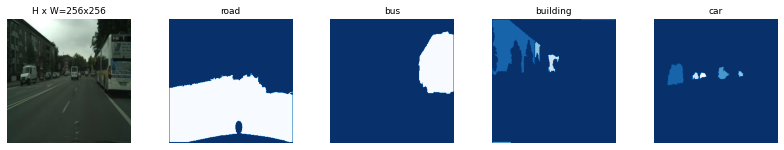

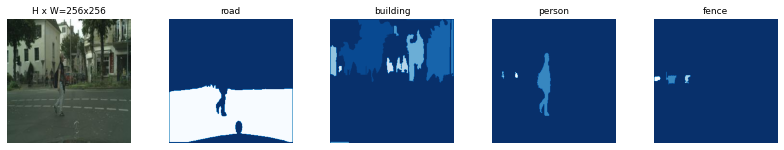

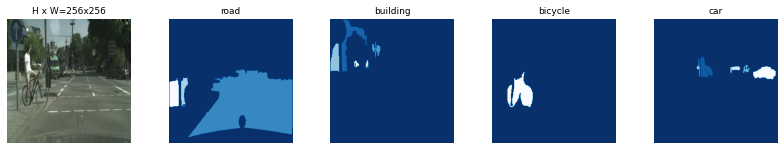

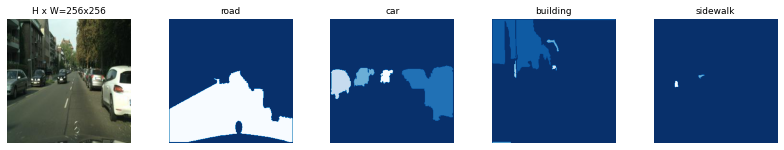

In [ ]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

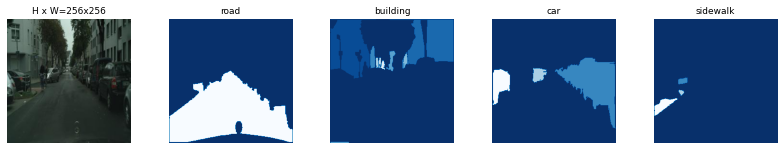

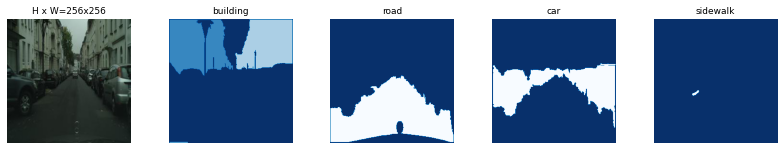

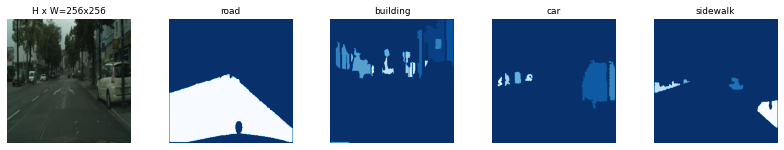

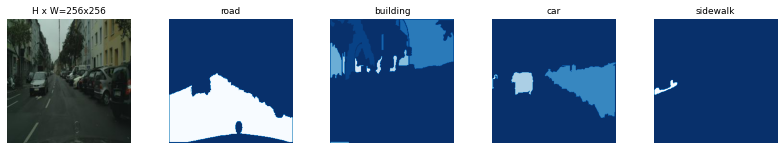

In [ ]:
# Load and display random samples
image_ids = np.random.choice(dataset_val.image_ids, 4)
for image_id in image_ids:
    image = dataset_val.load_image(image_id)
    mask, class_ids = dataset_val.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_val.class_names)

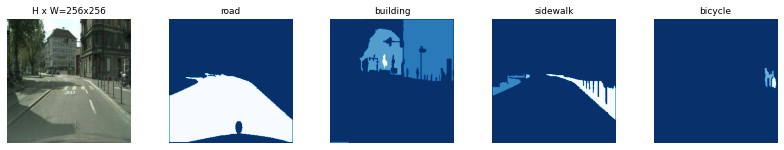

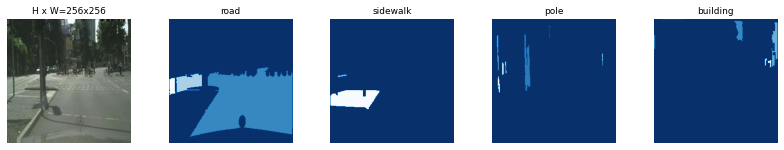

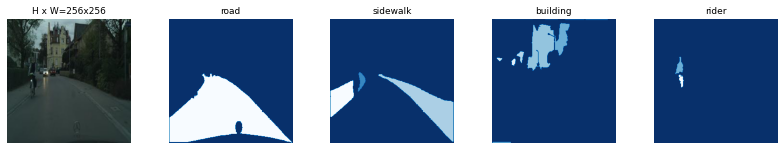

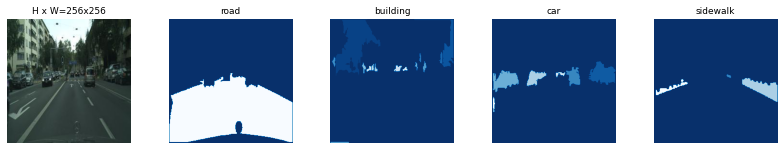

In [ ]:
# Load and display random samples
image_ids = np.random.choice(dataset_test.image_ids, 4)
for image_id in image_ids:
    image = dataset_test.load_image(image_id)
    mask, class_ids = dataset_test.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_test.class_names)

In [ ]:
def mAP(dataset, num):
  # Compute mAP with IoU = 0.3
  image_ids = np.random.choice(dataset.image_ids, num)
  image_ids = [i for i in range(num)]
  image_ids = [0]
  APs = []
  for image_id in tqdm(image_ids):
      # Load image and ground truth data
      image, image_meta, gt_class_id, gt_bbox, gt_mask =\
          modellib.load_image_gt(dataset, inference_config,
                                image_id, use_mini_mask=False)
      molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
      # Run object detection
      results = model.detect([image], verbose=0)
      r = results[0]
      # Compute AP

      AP, precisions, recalls, overlaps =\
          utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                          r["rois"], r["class_ids"], r["scores"], r['masks'], iou_threshold = 0.3)
      APs.append(AP)
      
  print("mAP: ", np.mean(APs))

100%|██████████| 1/1 [00:00<00:00,  4.14it/s]

mAP:  0.785804287658386


In [ ]:
import warnings
# ignore warnings
...
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    # place your skimage.transform.resize here

In [ ]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
model_path = model.find_last()

print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)
print('train')
mAP(dataset_train, 500)
print('val')
mAP(dataset_val, 100)
print('test')
mAP(dataset_test, 100)

Loading weights from  /content/drive/My Drive/Vin/logs/city_small20210114T0842/mask_rcnn_city_small_0717.h5


  0%|          | 0/500 [00:00<?, ?it/s]

Re-starting from epoch 717
train


  0%|          | 0/100 [00:00<?, ?it/s]

mAP:  0.7424252042846974
val


  0%|          | 0/100 [00:00<?, ?it/s]

mAP:  0.2561457886840734
test


100%|██████████| 100/100 [00:26<00:00,  3.76it/s]

mAP:  0.4525619271561242


0.08494043350219727
original_image           shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (34,)                 min:    0.00000  max:  256.00000  int64
gt_class_id              shape: (25,)                 min:    1.00000  max:   21.00000  int32
gt_bbox                  shape: (25, 4)               min:    1.00000  max:  255.00000  int32
gt_mask                  shape: (256, 256, 25)        min:    0.00000  max:    1.00000  uint8


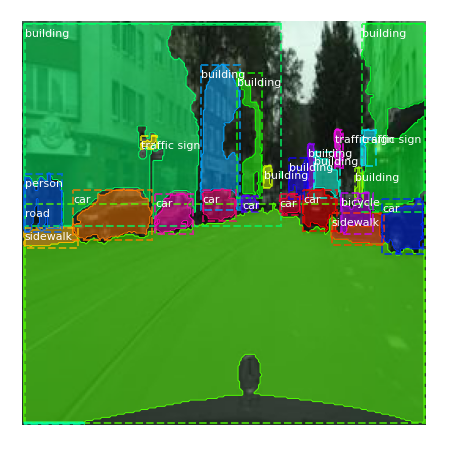

In [ ]:
# Show random gt image
# %%time
import time
s = time.time()
image_id = random.choice(dataset_test.image_ids)
image_id = 93
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_test, inference_config, 
                           image_id, use_mini_mask=False)
print(time.time() - s)
log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_test.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 34)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
time 0.15328526496887207


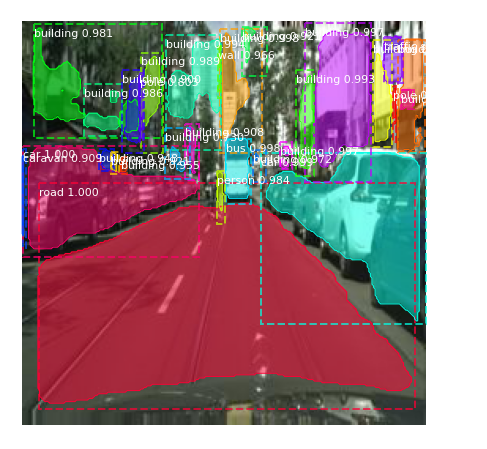

In [ ]:
from skimage.io import imread
# Inference one image
img = r'<image_path>'
original_image = imread(img)
s = time.time()
results = model.detect([original_image], verbose=1)
print('time', time.time() - s)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], ax=get_ax(),
                             show_bbox = True, captions = False, show_mask = True,
                            # path_path = '/content/drive/MyDrive/Vin/small_datasets/deno/aachen_000000_000019_leftImg8bit_.png'
                            )


In [ ]:

# Inference more image
path = '<dir of list of serie images>'
save_path = 'dir to save inferenced images'
imgs = os.listdir(path)
for img in tqdm(imgs):
    img = os.path.join(path, img)
    original_image = imread(img)
    s = time.time()
    results = model.detect([original_image], verbose=1)
    print('time', time.time() - s)

    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], ax=get_ax(), show_bbox = True, captions = False, show_mask = True,  path_path = save_path)

Output hidden; open in https://colab.research.google.com to view.